### Transfer Learning with Tensorflow : Scaling up

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2
import sklearn
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
import os 
import pathlib 
import random
import matplotlib.image as mpimg
import zipfile
import wget
import tensorflow_hub as hub

### Get Helper Functions

In [122]:
import requests
url = "https://raw.githubusercontent.com/Meta-c/Helper-ML/master/ML_functions.py"


response = requests.get(url)
code = response.text

exec(code)

In [3]:
train_dir="101_food_classes_10_percent/train/"
test_dir="101_food_classes_10_percent/test/"

In [123]:
class_names=os.listdir("101_food_classes_10_percent/train/")
print(class_names,len(class_names))

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

Image shape: (384, 512, 3)


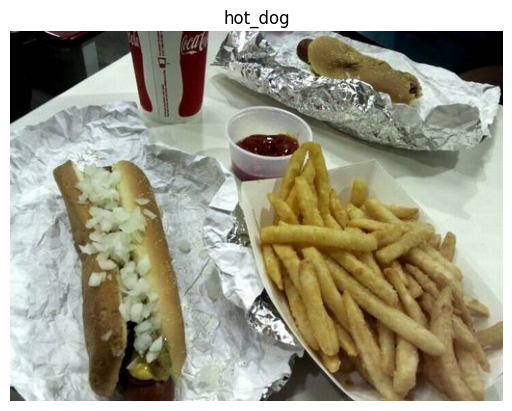

In [5]:
view_random_image(train_dir,class_names[55])

In [51]:
IMG_SIZE=(224,224)
BATCH_SIZE=32
train_data_all_10_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                            image_size=IMG_SIZE,label_mode="categorical",batch_size=BATCH_SIZE)

test_data=tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
image_size=IMG_SIZE,
label_mode="categorical",
batch_size=BATCH_SIZE,
shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big  model with transfer learning on 10% of 101 food classes

Steps for Goal:
* Create a  ModelCheckPoint Callback
* Create a Data augmentation layer 
* Build a headless (no top layers) Functional EffecientNetB0 backboned-model (we'll create our own output layer)
* Compile model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time) 

In [7]:
# Create checkpoint callback 
checkpoint_path='101_classes_10_percent_data_model_checkpoint'
checkpoint_callback=checkpoint_callback_fun(checkpoint_path,monitor="val_accuracy",save_weights_only=True,save_best_only=True)


In [8]:
# Create data augmentaion layer
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential 

# Setup data augmentation 

data_augmentation=Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
],name="data_augmentation")

In [9]:
# Setup the base model and freeze its layers

base_model =tf.keras.applications.EfficientNetB0(include_top=False)

base_model.trainable=False

# Setup model archeticture with trainable top layers

inputs=layers.Input(shape=(224,224,3),name="input_layer")
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs=layers.Dense(len(train_data_all_10_percent.class_names),activation="softmax",name="output_layer")(x)

model=tf.keras.Model(inputs,outputs)




In [10]:
model.compile(loss="categorical_crossentropy",
                     optimizer="Adam",
                     metrics=["accuracy"])

In [11]:
history_all_classes_10_percent=model.fit(train_data_all_10_percent,
                 epochs=5,
                 steps_per_epoch=len(train_data_all_10_percent),
        validation_data=test_data,
        validation_steps=int(0.15*len(test_data)),
        callbacks=[
           checkpoint_callback]
         )

Epoch 1/5
237/237 [==============================] - ETA: 0s - loss: 3.4672 - accuracy: 0.2520
Epoch 1: val_accuracy improved from -inf to 0.44995, saving model to 101_classes_10_percent_data_model_checkpoint
237/237 [==============================] - 151s 570ms/step - loss: 3.4672 - accuracy: 0.2520 - val_loss: 2.4326 - val_accuracy: 0.4499
Epoch 2/5
237/237 [==============================] - ETA: 0s - loss: 2.3437 - accuracy: 0.4597
Epoch 2: val_accuracy improved from 0.44995 to 0.50503, saving model to 101_classes_10_percent_data_model_checkpoint
237/237 [==============================] - 85s 357ms/step - loss: 2.3437 - accuracy: 0.4597 - val_loss: 2.0090 - val_accuracy: 0.5050
Epoch 3/5
237/237 [==============================] - ETA: 0s - loss: 1.9633 - accuracy: 0.5321
Epoch 3: val_accuracy improved from 0.50503 to 0.53019, saving model to 101_classes_10_percent_data_model_checkpoint
237/237 [==============================] - 78s 327ms/step - loss: 1.9633 - accuracy: 0.5321 - val_

In [12]:
model.evaluate(test_data)

790/790 [==============================] - 186s 234ms/step - loss: 1.7206 - accuracy: 0.5516


[1.7205737829208374, 0.5515643358230591]

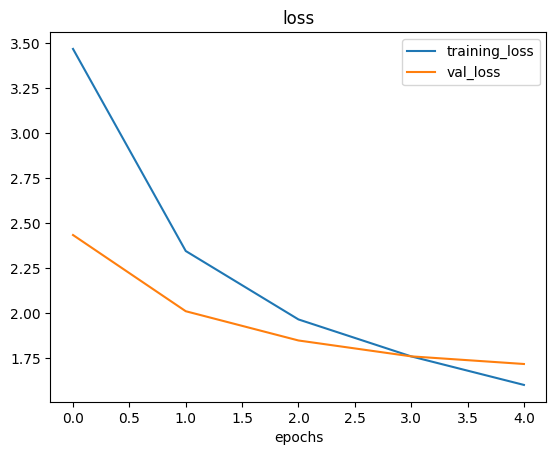

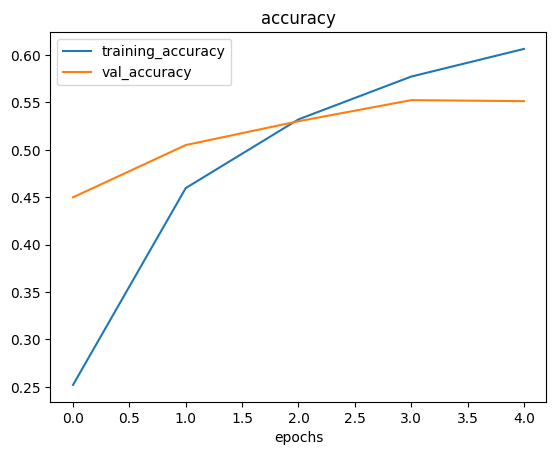

In [13]:
plot_loss_curves(history_all_classes_10_percent)

### Fine-Tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable=True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
    layer.trainable=False

In [14]:
# Recompile with lower learning rate (Best practice after fine tuning )
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=["accuracy"])


In [15]:
history_all_classes_10_percent_fine_tune=model.fit(train_data_all_10_percent,
                 epochs=10,
                 steps_per_epoch=len(train_data_all_10_percent),
        validation_data=test_data,
        validation_steps=int(0.15*len(test_data)),
        initial_epoch=history_all_classes_10_percent.epoch[-1],
         )

Epoch 5/10
237/237 [==============================] - 72s 269ms/step - loss: 1.4329 - accuracy: 0.6580 - val_loss: 1.6769 - val_accuracy: 0.5678
Epoch 6/10
237/237 [==============================] - 59s 248ms/step - loss: 1.4049 - accuracy: 0.6619 - val_loss: 1.6673 - val_accuracy: 0.5720
Epoch 7/10
237/237 [==============================] - 56s 238ms/step - loss: 1.3967 - accuracy: 0.6690 - val_loss: 1.6677 - val_accuracy: 0.5715
Epoch 8/10
237/237 [==============================] - 56s 235ms/step - loss: 1.3857 - accuracy: 0.6731 - val_loss: 1.6688 - val_accuracy: 0.5704
Epoch 9/10
237/237 [==============================] - 57s 238ms/step - loss: 1.3697 - accuracy: 0.6722 - val_loss: 1.6571 - val_accuracy: 0.5760
Epoch 10/10
237/237 [==============================] - 52s 218ms/step - loss: 1.3579 - accuracy: 0.6791 - val_loss: 1.6525 - val_accuracy: 0.5739


In [16]:
# Evaluate after fine tuning 
model.evaluate(test_data)

790/790 [==============================] - 83s 104ms/step - loss: 1.6665 - accuracy: 0.5650


[1.6664921045303345, 0.5650296807289124]

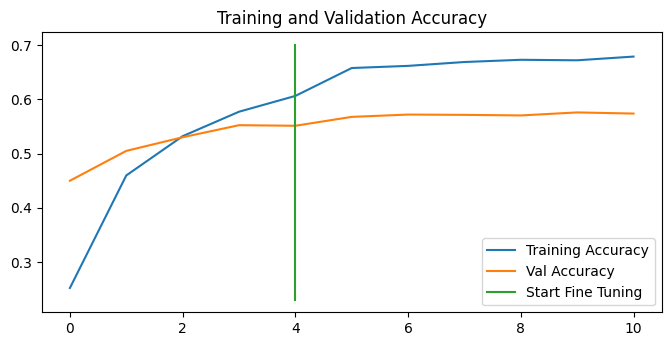

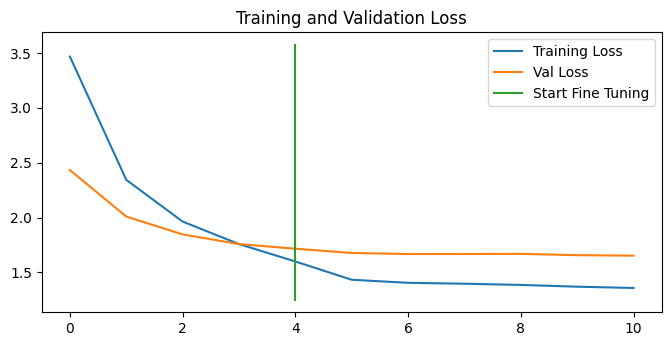

In [17]:
compare_histories(history_all_classes_10_percent,history_all_classes_10_percent_fine_tune,initial_epochs=5)

## Saving and loading model

In [18]:
# Save our  fine tune model

model.save("101_food_classes_10_percent_saved")

INFO:tensorflow:Assets written to: 101_food_classes_10_percent_saved\assets


In [22]:
# Load an evalute saved model 
loaded_model=tf.keras.models.load_model("101_food_classes_10_percent_saved")

In [23]:
# Evaluate loaded model 

loaded_model.evaluate(test_data)

790/790 [==============================] - 88s 108ms/step - loss: 1.6665 - accuracy: 0.5650


[1.6664931774139404, 0.5650296807289124]

In [26]:
model=tf.keras.models.load_model("06_101_food_class_10_percent_saved_big_dog_model")

In [27]:
model.evaluate(test_data)

790/790 [==============================] - 91s 111ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027218580245972, 0.6077623963356018]

## Making prediction

In [52]:
preds_probs=model.predict(test_data,verbose=1)

790/790 [==============================] - 78s 99ms/step


In [53]:
# shape of first ten
preds_probs[:10]

array([[5.9542034e-02, 3.5742187e-06, 4.1376837e-02, ..., 1.4138707e-09,
        8.3530751e-05, 3.0897583e-03],
       [9.6401680e-01, 1.3753220e-09, 8.4780250e-04, ..., 5.4286946e-05,
        7.8361605e-12, 9.8465835e-10],
       [9.5925879e-01, 3.2533586e-05, 1.4866921e-03, ..., 7.1891276e-07,
        5.4397378e-07, 4.0276002e-05],
       ...,
       [4.7313240e-01, 1.2931251e-07, 1.4805585e-03, ..., 5.9750013e-04,
        6.6969318e-05, 2.3469331e-05],
       [4.4571888e-02, 4.7265488e-07, 1.2258515e-01, ..., 6.3498455e-06,
        7.5318594e-06, 3.6778771e-03],
       [7.2438967e-01, 1.9249811e-09, 5.2310948e-05, ..., 1.2291392e-03,
        1.5792716e-09, 9.6395859e-05]], dtype=float32)

In [54]:
# First one 

y_preds=preds_probs.argmax(axis=1)

In [55]:
y_labels=[]

for images,labels in test_data.unbatch():
    y_labels.append(labels.numpy().argmax())

In [139]:
class_names[y_labels[300]],class_names[y_preds[300]]

('baby_back_ribs', 'baby_back_ribs')

In [82]:
len(y_preds),len(y_labels)

(25250, 25250)

In [83]:
from sklearn.metrics import accuracy_score

sklearn_accuracy= accuracy_score(y_true=y_labels,y_pred=y_preds)
sklearn_accuracy

0.6077623762376237

In [84]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [101]:
np.array(class_names)

array(['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio',
       'beef_tartare', 'beet_salad', 'beignets', 'bibimbap',
       'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad',
       'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake',
       'cheese_plate', 'chicken_curry', 'chicken_quesadilla',
       'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros',
       'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee',
       'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts',
       'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel',
       'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries',
       'french_onion_soup', 'french_toast', 'fried_calamari',
       'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi',
       'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon',
       'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog',
       'huevos_rancheros', 'hummus', 'ice_cr

In [104]:
confusion_matrix(y_true=y_labels,y_pred=y_preds,classes=class_names,figsize=100)

### Classification report

In [105]:
from sklearn.metrics import classification_report

print(classification_report(y_labels,y_preds))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [106]:
# get Dictionary of the classification report

classification_report_dict=classification_report(y_labels,y_preds,output_dict=True)

classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

## Plot all our classes F1-scores

In [108]:
# Create empty dictionary 
class_f1_scores={}
# Loop through classification report dictionary
for k,v in classification_report_dict.items():
    if k == "accuracy":
        break
    else:
        # Add class names and f1-scores to new dictionary
        class_f1_scores[class_names[int(k)]]=v["f1-score"]

class_f1_scores       

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheesecake': 0.5654135338345864,
 'cheese_plate': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [110]:
# Turn f1-scores into dataframe for visualization

f1_scores=pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                        "f1-score":list(class_f1_scores.values())}).sort_values("f1-score",ascending=False)

f1_scores[:10]

,class_names,f1-score
33,edamame,0.937143
63,macarons,0.895397
75,pho,0.866538
91,spaghetti_carbonara,0.847656
69,oysters,0.834008
68,onion_rings,0.832618
65,mussels,0.820000
88,seaweed_salad,0.813008
64,miso_soup,0.812977
45,frozen_yogurt,0.811429


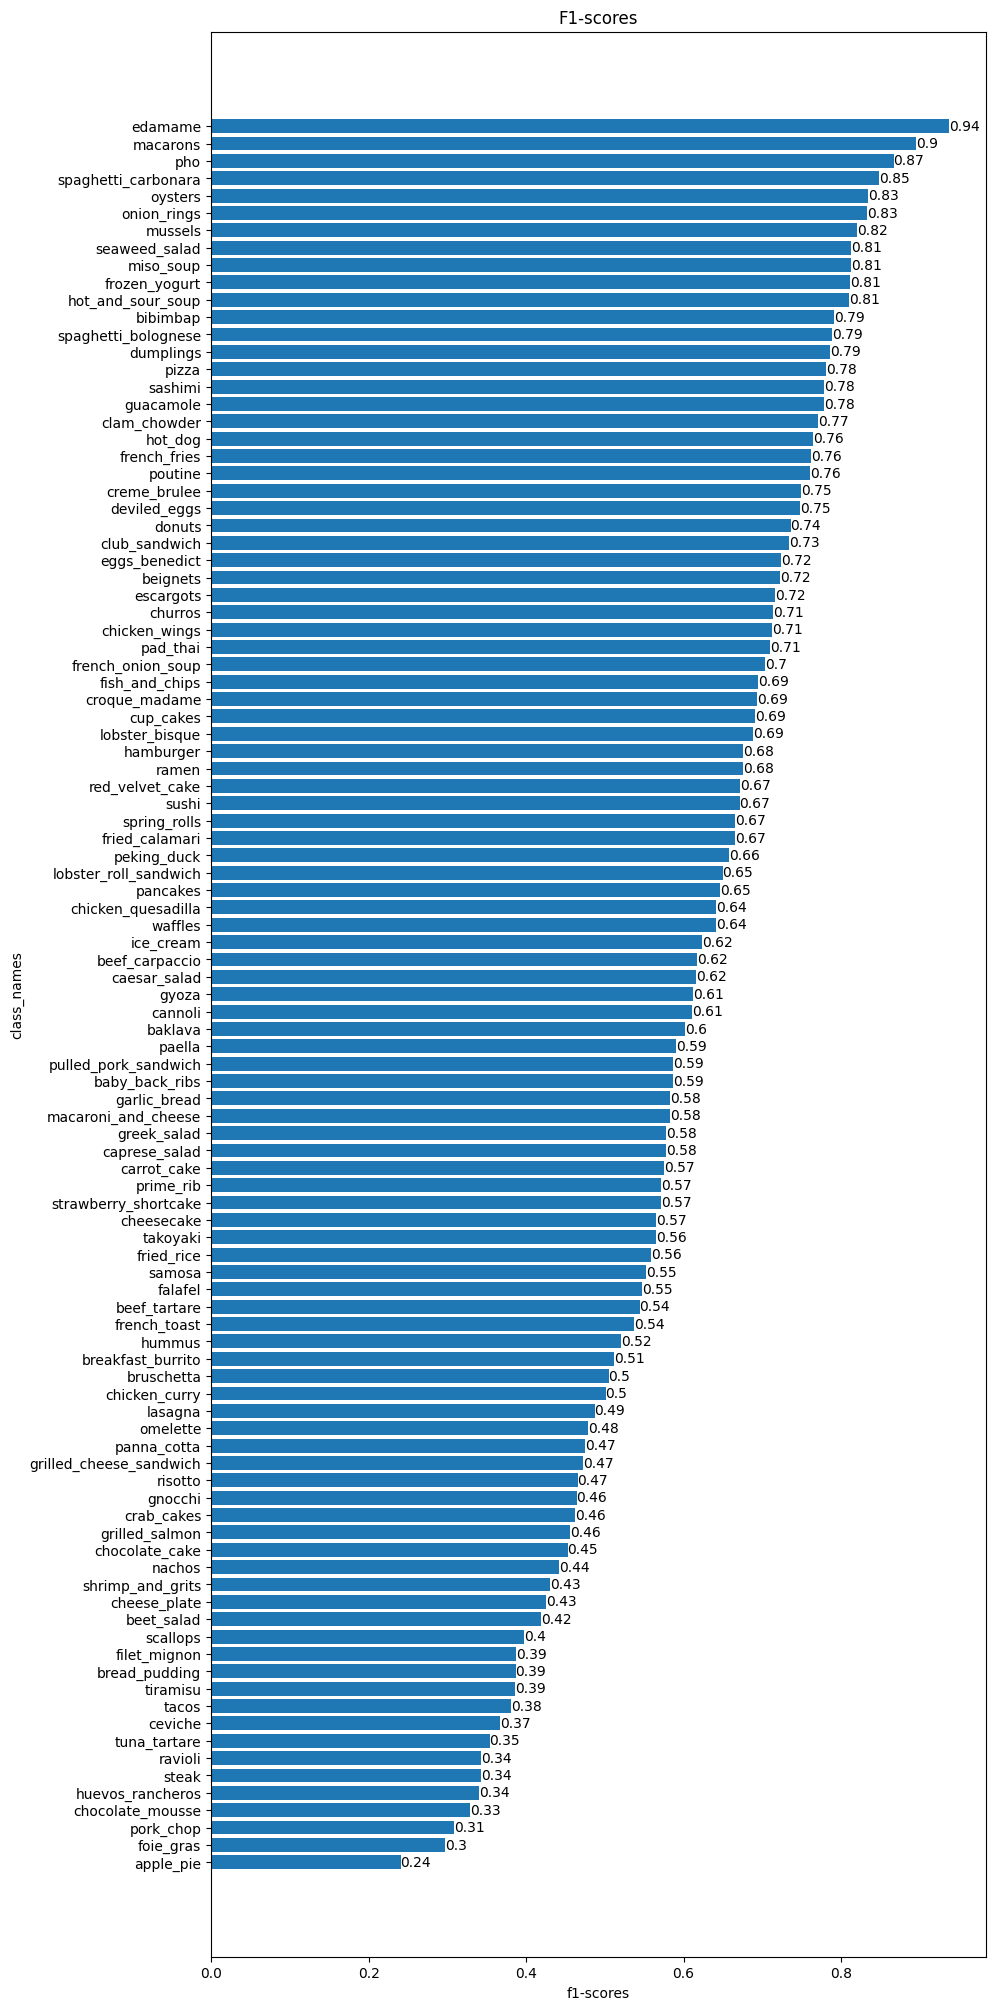

In [118]:
# plot the horizontal bar chart
fig, ax = plt.subplots(figsize=(10,25))
bars=ax.barh(y=f1_scores['class_names'], width=f1_scores['f1-score'])

# add the values to the end of each bar
for bar in bars:
    value = bar.get_width()
    ax.text(value, bar.get_y() + bar.get_height() / 2, f'{value.round(2)}', ha='left', va='center')




# set the plot title and axis labels
ax.set_title('F1-scores')
ax.set_xlabel('f1-scores')
ax.set_ylabel('class_names')
ax.invert_yaxis()
# display the plot
plt.show()

### Visualizing predictions on custom images

In [131]:
class_names[2]

'baklava'

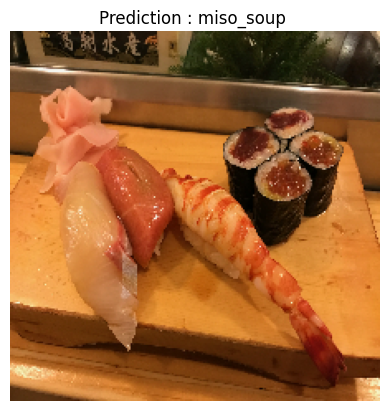

In [141]:
# load and perpare image 
pred_and_plot(model,'custom_food_images/sushi.jpeg',224,class_names)